<!-- metadata: title -->
# Unit Trust Investments in Kenya: Money Market Funds(KES) Analysis

<!-- metadata: subtitle -->
> ### Can Investment in Money Market Funds in Kenya gurantee capital preservation? 

**Published Date:**
<!-- metadata: date -->
2024-03-03
<!-- metadata: -->

**Date Modified:**
<!-- metadata: date-modified -->
2024-05-05
<!-- metadata: -->

<!-- metadata: keywords, is_array=true -->
**Keywords:**
  - money
  - kenya
  - unit-trusts
  - money-market-funds
  - MMF

<!-- metadata: categories, is_array=true -->
**Categories:**
  - kenya unit trusts
  - data science
  - money

## Description

<!-- metadata: description -->
Money Market Fund (MMF) is a unit trust investment, where fund managers raise money from public investors, and invest it collectively. Money Market Fund as a financial asset is short-term and highly liquid. Compared to bank deposits, Money Market offers a higher interest with a lower barrier of entry, in Kenya. Besides a higher interest, money moarket accounts offer compound interest unlike bank deposts which mostly offer simple interest. We will analyze Money market funds in Kenya in general using public information and hopefully paint a picture of the state of unit trust investments in Kenya.

## Introduction

According to Central Bank of Kenya records, Kenya had over 77.92 million registered mobile money accounts, as of June 2024 ^[[CBK Mobile Payments](https://www.centralbank.go.ke/national-payments-system/mobile-payments/), see [PDF](./www.centralbank.go.ke-national-payments-system-mobile-payments.pdf)]. Compared to the Kenyan population of slightly above 54 million ^[[Kenya Population from year 1974 to year 2022](https://toknow.ai/posts/kenya-population-from-1974-to-2022/)], nearly every Kenyan has a means to transact money, technically banked. Research by J. Degenhard ^[J. Degenhard, Jan 30, 2024. <https://www.statista.com/forecasts/1149636/bank-account-penetration-forecast-in-kenya>] estimates that the banking penetration in Kenya is approximately `96.43%` and will increase to `99.9%` by year 2026.

Several research conclude that financial access often follows fiancial literacy. However, to know unit trusts investments requires understanding finacial instruments and assets beyoud the general fiancial education. One of the most attractive entry level high-yield financial asset is the unit trust, specifically the Money Market Funds (MMF). With some fund managers allowing mobile money accounts as an alternative to a bank account number, it becomes very easy to start, deposit, withdraw from a Money Market Fund account. Unlike bank deposits that usually offer simple interest, Money Market Fund accounts offer a **DAILY** compounding interest.

<!-- ADD IFRAME OF THE CALCULATOR AT HUGGING SPACE SPACES -->

### Who pays Fund Managers for managing money market fund investments?

You don't manage money market funds accounts. Fund managers invest the money on your behave. They invest the funds mostly in shortterm government papers (T-bill), company papers, bank deposits and a small portion is invested in long term asserts like real estate or long term bonds. Fund managers take a `2%` fee from the profit made from each of their investors. This provides an incentive to maximize the profit their investors get. Typically, this leaves with an net interest of between `1% - 5%` below the government of Kenya T-bills. For example, the current Treasury Bills on Offer at <https://www.centralbank.go.ke/bills-bonds/treasury-bills/> are:


| Term    | Issue Number | Auction Date    | Value Dated     | Previous Average Interest Rate |
|---------|--------------|-----------------|-----------------|--------------------------------|
| 91-DAY  | 2589/091     | 1st August 2024 | 5th August 2024 | 16.000%                        |
| 182-DAY | 2562/182     | 1st August 2024 | 5th August 2024 | 16.8506%                       |
| 364-DAY | 2516/364     | 1st August 2024 | 5th August 2024 | 16.9212%                       |

: Treasury Bills on offer as at 29/07/2024 {#tbl-treasury-bills-on-offer-as-at-29-07-2024 .striped }

Going by the previous assumption, our money market fund account should currently return between `15% - 11%` approximately. Its important to recognize that how the fund managers invest determine the yield. for example, a fund manager who priritizes security over interest invest most of their money in safer assets that may have less return. The size of the investment portfolio also matters. fund managers with big assets have a harder time adjusting to higher interests, but also lower chances of downward fluctuations. Also, reputable fund managers who have a small porfolo have more incentive to lure more customers, so they take a less fee. Also, with a less assets to manage, a fund manager can invest all in a government paper, significanly offering a higher return, but theoretically exposing the investors to risk. Although it may be safe to say that the government paper is safe in that the government of kenya has never defaulted on any of its debt obligations, the investment is not diversified, which is risky. Some fund managers certainly offer a higher interest that that this, sometimes matching or surpusing government papers. This might be okay, but you owe to yourself an even greater burden of due dilligence.



### Are Money market funds regulated in Kenya?

Unit trust Investments such as Money Market Funds are regulated by Capital Markets Authority (CMA)^[Capital Markets Authority (CMA) <https://www.cma.or.ke/about-us/>]. The Capital Markets Authority (CMA) is an independent public agency established in 1989 by an Act of Parliament, Capital Markets Act, Cap 485A ^[[THE CAPITAL MARKETS ACT - CHAPTER 485A - Revised Edition 2023 [1989] - Published by the National Council for Law Reporting](https://web.archive.org/web/20240730193048/https://www.cma.or.ke/download/18/acts/5077/capital-markets-act-2023.pdf)]. CMA is charged with the responsibility to oversee, license, and monitor the activities of market intermediaries, including the Stock Exchange, the Central Depository and Settlement Corporation(CDSC), Online Forex, Commodities and Regulated Exchanges^[CMA Regulatory Framework - Acts and Regulations - <https://www.cma.or.ke/regulatory-framework/>]. The CMA's primary mandate is to promote and maintain an orderly, fair, and efficient capital market in Kenya. Over the years, the CMA has regulated and supervised several market milestones such as the automation of trading at the Nairobi Securities Exchange^[[The Effect of Automation on Stock Market Trade](https://web.archive.org/web/20171031042240/http://erepository.uonbi.ac.ke/bitstream/handle/11295/93863/Mwangi%20Michael%20M_The%20Effect%20of%20Automation%20on%20Stock%20Market%20Trade%20Volume%20at%20the%20Nairobi%20Securities%20Exchange..pdf)] ^[[NSE HISTORY - PDF](https://web.archive.org/web/20240617053341/https://www.nse.co.ke/wp-content/uploads/final-ar-min.pdf), [NSE HISTORY - Website](https://web.archive.org/web/20240730203221/https://www.nse.co.ke/our-story/)], the introduction of derivative markets, and the development of a robust regulatory framework^[<https://web.archive.org/web/20240718122736/https://www.cma.or.ke/regulatory-framework/>]. However, it has also faced challenges, such as insider trading scandals^[[Legal battle deny CMA insider trading fines](https://web.archive.org/web/20221007173416/https://www.businessdailyafrica.com/bd/economy/legal-battle-deny-cma-insider-trading-fines-3680374)] ^[[Insider Trading in Kenya and the Effectiveness of Its Sentencing in Light of Its Definition and Punishment in the United States of America and the United Kingdom](https://dx.doi.org/10.2139/ssrn.4171294)] ^[[Tightening Loose Ends: Capital Markets Authority’s Power and Role in Combating Insider Trading](https://web.archive.org/web/20240730210258/https://www.oraro.co.ke/tightening-loose-ends-capital-markets-authoritys-power-and-role-in-combating-insider-trading/)] and the collapse of some investment firms^[[CMA to drop troubled firms from Kenyan stock market](https://web.archive.org/web/20240412114910/https://www.businessdailyafrica.com/bd/markets/capital-markets/cma-to-drop-troubled-firms-from-kenyan-stock-market-4536842)] ^[[Hard lessons in the collapse of stocks firms](https://web.archive.org/web/20240730212311/https://nation.africa/kenya/life-and-style/money/hard-lessons-in-the-collapse-of-stocks-firms-615610)] ^[[CMA to tighten unit trusts oversight after investor losses](https://web.archive.org/web/20240730212459/https://www.businessdailyafrica.com/bd/markets/market-news/cma-to-tighten-unit-trusts-oversight-after-investor-losses-2278788)], which have tested its regulatory effectiveness.

Below is a non exhaustive summary of some key areas that are regulated by CMA regarding Money Market Funds.

1. **Licensing requirements:** *Fund managers must obtain a license from the CMA and meet minimum capital requirements.*<br/>
According to the Capital Markets (Collective Investment Schemes) Regulations, 2001 (last amended in 2021), fund managers in Kenya must obtain a license from the Capital Markets Authority (CMA) and meet specific capital requirements. For money market funds, the minimum paid-up capital requirement is 10 million Kenyan Shillings, while for other types of funds, it's 50 million Kenyan Shillings. Additionally, all fund managers must maintain a minimum net capital of 10 million Kenyan Shillings throughout their operations. These funds must be kept in a bank account or invested as specified by the CMA^[[Capital Markets (Collective Investment Schemes) Regulations, 2001 (last amended in 2021)](https://web.archive.org/web/20240730214559/https://www.cma.or.ke/download/34/regulations/5017/the-capital-markets-collective-investment-schemes-regulations-2023.pdf)].

2. **Investment restrictions:**<br/>Money market funds are required to invest in low-risk, short-term debt instruments with a maximum maturity of 18 months ^[[Capital Markets (Collective Investment Schemes) Regulations, 2001 (last amended in 2021)](https://web.archive.org/web/20240730214559/https://www.cma.or.ke/download/34/regulations/5017/the-capital-markets-collective-investment-schemes-regulations-2023.pdf), Part VIII, section 102.1.a].

3. **Diversification rules:** *Funds must maintain a diversified portfolio, with limits on exposure to single issuers or sectors.* <br/>
Regulation 78(1) states that a scheme shall not invest more than 25% of its net asset value in any one issuer, with an exception for government securities where the limit is 30% ^[Regulation 78(1) and Regulation 78(2)(b) of the Capital Markets (Collective Investment Schemes) Regulations, 2001.].

4. **Valuation and pricing:** *Daily valuation of fund assets and use of amortized cost^[[Amortized cost refers to the purchase price of an asset, adjusted for factors like interest rates and payments over the lifetime of the asset. It allows assets to be valued on financial statements in a way that accounts for changes in value over time as the asset is used or paid off.](https://www.google.com/search?q=amortized+cost)] method for certain short-term securities.* <br/>
Fund managers must provide accurate and up-to-date valuations of their funds' assets, which is crucial for determining the price at which units in the fund can be bought or sold ^[Regulation 48(1) and Regulation 49(5) of the Capital Markets (Collective Investment Schemes) Regulations, 2001].

5. **Disclosure requirements:** *Regular reporting of fund performance, fees, and portfolio composition to investors and the CMA.* <br/>
The Capital Markets (Collective Investment Schemes) Regulations, 2001, outline key disclosure requirements for Kenyan fund managers. These include weekly publication of unit prices (Regulation 40), quarterly reports to the CMA and trustees on portfolio, activities, and performance (Regulation 42), and annual audited financial statements. Regulation 45 requires distribution of detailed annual and semi-annual reports to all investors, covering financial information, portfolio composition, and performance metrics. These rules ensure transparency in fund operations and regular communication with both regulators and investors.

6. **Risk management:** *Implementation of robust risk management systems and stress testing procedures.* <br/> 
Part IV, Section 9 of the Capital Markets (Risk Based Supervision of Licensees of the Capital Markets Authority) Guidelines, 2020, guidelines requires licensees, including fund managers, to develop and implement a risk management framework that includes stress testing and covers the identification, assessment, monitoring, controlling, and reporting of all material risks.

7. **Liquidity requirements:** *Maintaining a minimum percentage of assets in highly liquid instruments to meet redemption requests.* <br/> A person is eligible for a licence to act as a trustee of a collective investment fund if that person has a minimum liquid capital of five million shillings or eight per cent of its liabilities which must be maintained throughout the duration of the license^[PART V 32 (c), Capital Markets (Collective Investment Schemes)].

8. **Corporate governance:** *Appointment of independent trustees and compliance with the Code of Corporate Governance Practices for Issuers of Securities to the Public.* <br/> 
A person is eligible for a licence to act as a trustee of a collective investment fund if has as its directors and shareholders, persons who are fit and proper as provided under section 24A of the Act ^[PART V 32 (c), Capital Markets (Collective Investment Schemes)]. Additionally, the Code of Corporate Governance Practices for Issuers of Securities to the Public, 2015, provides comprehensive guidelines for corporate governance, which fund managers issuing securities to the public must comply with.

9. **Marketing and advertising:** *Adherence to strict guidelines on marketing materials and performance representations.* <br/>
The Capital Markets (Collective Investment Schemes) Regulations, 2001, provide guidelines on marketing and advertising for collective investment schemes. These regulations require CMA approval for all advertisements, mandate disclosure of potential value fluctuations, set standards for performance representations, and require warnings about past performance.

10. **Investor protection:** *Establishment of clear procedures for handling investor complaints and maintaining segregated client accounts.* <br/> Regulation 22 requires the establishment of procedures for handling investor complaints, while Regulation 31 mandates the maintenance of segregated client accounts ^[The Capital Markets Act, Cap 485A, and the Capital Markets (Conduct of Business) (Market Intermediaries) Regulations, 2011]. Some fund managers dont have a way to tell that you have a unique and segregated account. In this era where automation is increadibly affordable, always prefer fund managers who have an online platform, an app or any other means where you can clearly see your money, initiate withdrawals and raise support tickets in real time. Some fund managers prefer you literally call them or explicitely write them an email to request a status of your account. 

If you see a fund manager breaking any of these regulations, take it as a red flag and prefarably follow up the matter with CMA at their complaint page, <https://portal.cma.or.ke/complaints/>. Unless your risk appetite is pretty high, in which case you should be not considering investing Money Market Funds, always prefer safely over interest... better safe than sorry!

<!-- Unit trusts are required to publish their daily and effective annual yields on the daily newspapers, and thus an investor can therefore always confirm the value of their investment as well as benchmark the performance against other unit trusts. It is also mandatory for the scheme to issue monthly statements showing an investor’s investments position.^[Investing in Unit Trust Funds; 19 May, 2019; see <https://cytonn.com/topicals/investing-in-unit-1>]^[Publishing daily the price of units in at least two daily newspapers of national circulation,
in English. <https://cma.or.ke/wp-content/uploads/2023/03/CMA-Handbook-2021.pdf> ]

Unit Trust is required to have at least three trustees, ^[https://cma.or.ke/wp-content/uploads/2023/03/CMA-Handbook-2021.pdf]

^[https://www.google.com/search?q=unit+trusts+are+mandated+to+inform+customers+of+yileds+CMA&sca_esv=d7f5b94d2e0e1e85&sca_upv=1&rlz=1C5GCEM_en&sxsrf=ADLYWIIy4tzw-iKWAAcD-6cN8riYTbVjdA%3A1720446046799&ei=XuyLZqa8MLSOxc8Pw42giA4&ved=0ahUKEwim4-X7yJeHAxU0R_EDHcMGCOEQ4dUDCA8&uact=5&oq=unit+trusts+are+mandated+to+inform+customers+of+yileds+CMA&gs_lp=Egxnd3Mtd2l6LXNlcnAiOnVuaXQgdHJ1c3RzIGFyZSBtYW5kYXRlZCB0byBpbmZvcm0gY3VzdG9tZXJzIG9mIHlpbGVkcyBDTUEyBxAhGKABGAoyBxAhGKABGApI1RFQvwFYtw5wAXgBkAEAmAHeAqABlQmqAQUyLTMuMbgBA8gBAPgBAZgCBaACownCAgoQABiwAxjWBBhHwgIFECEYnwWYAwDiAwUSATEgQIgGAZAGCJIHBzEuMC4zLjGgB5cW&sclient=gws-wiz-serpsssss] -->

## Comparison: Money Market Investments vs. Bank Deposits in Kenya

| Feature | Money Market Funds (KES) | Bank Deposits (KES) |
|---------|--------------------------|----------------|
| Withdraw time | Same day to 3 business days depending on account type and fund manager. Joint accounts may take longer than personal accounts. Withdrwal via bank account may take longer than MPESA withdrwals. | Same day to 7 business days, depending on account type. Same day for Saving account. |
| Adding new Money | Can be done easily, often with minimum amounts | Can be done easily, sometimes with minimum amounts depending on account type  |
| Interest type | Generally Compound Interest | Usually Simple interest |
| Risk level | Low to moderate. There is about 25% chance you can loose your principal investment, or part ot it. | Low. There is about 15% you can loose your principle investment, or part of it. |
| Secured | Not secured by government | Secured up to Ksh 500,000 by KDIC^[[Kenya Deposit Insurance Corporation](https://kdic.go.ke/)] |
| Penalties | May have penalties for more than two withdrawals per month. No penalty for Cancelation. | Savings accounts - no penalty for withdrawal, may have penalty on cancelation; <br/><br/> Fixed deposits - may have penalties for withdrawing and cancelation. |
| Creating an account | Simpler process and usually require lower initial deposit, approximately Ksh 5,000; your KRA PIN and one or more KYC documents | Simple process, higher initial deposit, averagely Ksh 20,000. |
| Interest rate | Generally higher than inflation (approximately 10-17% p.a.)**<br/>The interest rates determined by daily market yield, with factors such as Treasury bills greately determining the yield. | Generally lower than inflation with exception of bank campaign offers to attract new customers. |
| Minimum balance | Often No minumum balance. You can withdrawl all your money. | Savings accounts may have minimum balance. Fixed deposits can be withdrawn fully withput a minimum balance. |
| Account management | Fund managers manage the account, taking a percentage of the profit, usually 2%. | No necessary management. |
| Accessibility | Less accessible, may require sending an email to initiate withdrawals. Some fund managers have mobile or wen applications but transactions need to be approved. | Highly accessible through bank branches and digital platforms |
| Investment options | Mostly T-bills, commercial papers, and bank deposits. | No disclosure of where the money is invested. |
| Term length | Flexible, short-term to long-term. You can invest today and withdraw after one week, without a pernalty, and having earned interest for that one week. | Fixed on either minimum period before withdrwal (approximately 6 months), or fixed intervals of withdrawal. |
| Yield fluctuations | More sensitive to market conditions | More stable, fixed interest. |

## Data

In [1]:
#| code-fold: true
#| code-summary: "Show python imports"

import sys
import os

# Add parent directory to sys.path
root_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.append(root_dir)

%reload_ext autoreload
%autoreload 2

In [2]:
#| code-fold: true
#| code-summary: "Show python imports"

import pandas as pd
from pyppeteer.page import Request, Page
import asyncio
import io
from bs4 import BeautifulSoup, Tag
from urllib.request import urlopen
from matplotlib import pyplot as plt
import json5 as json
from tqdm import tqdm
import re
import webbrowser
from typing import Callable
from copy import copy
from datetime import datetime, timedelta
import plotly.io as pio
import plotly.express as px
from json2txttree import json2txttree
from python_utils.web_screenshot import web_screenshot_async
from python_utils.get_browser import get_browser_page_async

# https://github.com/microsoft/vscode-jupyter/issues/6999
pio.renderers.default = "plotly_mimetype+notebook_connected"

### Approved Fund Managers

To get a comprehensive list of approved fund managers, we crawled Capital Markets Authrity (CMA). They have  published a list of approved licencies in various capital markets. We will craw from <https://www.cma.or.ke/licensees-market-players/>.

#### Screenshot of the page

Lets start with a screenshot of the page:

In [ ]:
async def fund_manager_click_fn(page: Page):
    """
    Clicks on the 'FUND MANAGERS' accordion element in the page, so we can see it.

    Args:
        page (Page): The page object representing the web page.

    Returns:
        None
    """
    await page.waitForSelector('ul.module-accordion')
    elements = await page.querySelectorAll('li .accordion-title')
    # Iterate through the elements to find the one containing 'FUND MANAGERS'
    for element in elements:
        text_content = await page.evaluate('(element) => element.textContent', element)
        if 'FUND MANAGERS' in text_content:
            # Click on the target element
            await element.click()
            break
    else:
        print('Element not found')
    await page.waitForSelector('li.current.builder-accordion-active')
    await asyncio.sleep(1)

# Take a screenshot
await web_screenshot_async(
    # Fund manager URL
    "https://www.cma.or.ke/licensees-market-players/", 
    action = fund_manager_click_fn,
    width=1500)

#### Crawling

Next, let's try grab the fund managers table into a dataframe that we can work with.
Below is the list of all the certified fund mangers in Kenya by CMA.^[Approved Fund Managers by CMA. <https://www.cma.or.ke/licensees-market-players/>]

In [3]:
# Fetch the HTML content of the FUND_MANAGER_URL
url_response = urlopen("https://www.cma.or.ke/licensees-market-players/").read()

# Find the HTML table containing the fund managers information
fund_managers_html_table = BeautifulSoup(url_response, "html.parser")\
    .find('span', string="FUND MANAGERS")\
        .parent\
            .parent\
                .parent\
                    .find('table')

# Convert the HTML table to a pandas DataFrame
fund_managers_df = pd.read_html(io.StringIO(str(fund_managers_html_table)))[0].dropna()

# Display the fund managers DataFrame
fund_managers_df

,NAME,ADDRESS,LICENCE NO.
0,Orient Asset Managers Limited,"P.O. Box 34530-00100, Nairobi",23.0
1,Amana Capital Limited,"P.O. Box 9480-00100, Nairobi",24.0
2,Apollo Asset Management Company Limited,"P.O. Box 30389-00100, Nairobi",25.0
3,Britam Asset Managers (Kenya) Limited,"P.O. Box30375-00100, Nairobi",27.0
4,Metropolitan Canon Asset Managers Limited,"P.O. Box 30216-00100, Nairobi",28.0
5,Nabo Capital Limited,"P.O. Box 10518-00100, Nairobi",29.0
6,CIC Asset Managers Limited,"P.O. Box 59485-00200, Nairobi",30.0
7,Co-op Trust Investment Services Limited,"P.O. Box 48231-00100, Nairobi",31.0
8,FCB Capital Limited,"P.O. Box 26219-00100, Nairobi",32.0
9,Fusion Investment Management Limited,"P.O. Box 47583-00100, Nairobi",33.0


We have `34` approved fund managers as at {{< meta date-modified >}}. Its important to note that this is **MAY NOT*** be an exhaustive list of all licenced Fund managers. For example, *Mali Money Market Fund* ^[[Frequently Asked Questions / Mali](https://www.safaricom.co.ke/media-center-landing/frequently-asked-questions/mali)] ^[[Safaricom to launch unit trust, new savings service](https://www.businessdailyafrica.com/bd/markets/capital-markets/safaricom-to-launch-unit-trust-new-savings-service-2288556)] which seems to be wholly or partly owned by the Kenyan Telecommunications company, Safaricom PLC ^[[M-PESA / M-PESA Services / Wealth / Mali](https://www.safaricom.co.ke/main-mpesa/m-pesa-services/wealth/mali)], is not listed among licenced fund managers. According to Business Daily ^[[Safaricom's Mali unit trust asset base hits Sh1.4bn](https://www.businessdailyafrica.com/bd/markets/capital-markets/safaricom-s-mali-unit-trust-asset-base-hits-sh1-4bn--4582142)], Mali MMF is administered by Genghis Capital Limited, which is listed by CMA as an Investment Bank. Genghis Capital Limited also has its own unit trust fund called Gencap Hela Imara Money Market Fund ^[[Genghis Capital Unit Trust Fund](https://genghis-capital.com/asset-management/money-market-fund/)], which raises a potential conflict of interest. 
Similaraly, there are fund managers that no longer offer Unit Turst investments under Money Makrket Funds, such as Zimele ^[[Zimele Savings Plan Transition: From Money Market to Fixed Income Fund](https://www.zimele.co.ke/zimele-savings-plan-transition-from-money-market-to-fixed-income-fund/)]. Before you choose a fund manager, make sure you do your due diligence, and understand the risks you are willing to take.

:::{.callout-note}
Always invest with caution when important information is missing, unclear or overly complicated.
:::

#### Agumenting and Cleaning the fund managers list

The address of `African Alliance Kenya Asset Management Limited` doesnt seem to be valid, lets populate it with `P.O. Box 27639 Nairobi 00506`

In [4]:
fund_managers_df.loc[fund_managers_df['LICENCE NO.'] == 165, 'ADDRESS'] = 'P.O. Box 27639 Nairobi 00506'
fund_managers_df.loc[fund_managers_df['LICENCE NO.'] == 165, :]

,NAME,ADDRESS,LICENCE NO.
26,African Alliance Kenya Asset Management Limited,P.O. Box 27639 Nairobi 00506,165.0


##### Adding More columns the fund managers

In [ ]:
## use json5 to read JSON with comments
fuller_fund_managers_df = pd.DataFrame(json.loads(open('approved.jsonc', 'r').read()))
fuller_fund_managers_df

Lets try add more details to the dataframe for completeness. 
- Location Coordinates (and google map)
- Risk Pfile
- Launch Date
- Risk Profile
- Trustee
- Custodian
- Auditors
- Minimum Investment
- has USSD platform
- Initial Fee
-ttps://cytonnreport.com/research/cmmf-fact-sheet-april-2021
- Distribution
-
-KE NOTE OF MERGED OBSOLTELE MA- Duration to withdraw
-- has online portal
- Withdraw chargessssss
- Contacts
-leds published!
- allows MPESA
- pHONE NUMBER
- EMAIL
- website
- has USSD platform

- * ADD A COLUMN TO DETERMINE IF I CAN WITHDRWAL ALL MY MONEY AFTER A WEEK AND IF THE INTESRSE IS COMPOUNDED DAILY!

<!-- 
** https://chatgpt.com/c/db7eb613-2d99-4e1d-906f-0518a4bf8a74

https://cytonnreport.com/research/cmmf-fact-sheet-june-2021

https://cytonnreport.com/research/cmmf-fact-sheet-may-2021

https://cytonnreport.com/research/cmmf-fact-sheet-april-2021

https://ke.cicinsurancegroup.com/mmf/

https://ke.britam.com/save-and-invest/business/invest/unit-trust-funds/unit-trusts


TAKE NOTE OF USD MMF
TAKE NOTE OF MERGED OBSOLTELE MANAGERS, EG ALPHA/KASHA NPW ORIENT -->

### Yield Data

Despite the requirements to have the daily yield published in two national newspapers, it is fairly tasking to find a good data source. Also, since there dont have to publish the newspapers that have digital precenese, it also becomes difficult to capture all yileds without visiting the library and grabbing the actual physical copies, which makes this task very expesnsive. Again, getting historical data is also not free, most old newspaper records are sold, adding up the cost. Fortunately, since 2014, Cytonn Fund Managers has been doing free market research, and publishing them at <https://cytonnreport.com/>. A few fund managers publish their daily yields at their websites, but without historical data; just the current day's yield, which effectively makes this data unuseful for analysis.

We settled on crawling and analysing the massive cytton research data that is publicly available since 2014. With over 600 reports with, we crawl each of the reports in a way that doesnt break their systems, or deny others the service, extract the table, aggregate the table results and analyze the tables. We checked with Cytonn's terms of service. users are allowed to use their copyright data in accordance with fair use/dealing, ^[Reproduction is prohibited other than in accordance with the copyright notice, which forms part of these terms and conditions. <https://cytonn.com/terms-of-use> ]. To allow others to reproduce this analysys, we will save a copy of the crawled raw data for future researchers and data enthusisists.

<!-- According to Capital Markets Authority, fund managers are required to publish their yields daily in a reputable newspaper. What this means accessing hostorical records requires a significant investment in time to collect, aggregate and validate the published yields. That not withstanding, two very important questions become obvious:
 - what is a reputbale newspaper? 
 - what yield do they publish, gross or net?
 - What picture does an anualized daily rate paint?
 - Is interest deffered or carried forward (reporting a convervative figure and retaining the rest for rainy day to preserve a picture of good performance)?

Luckily, one of the fund managers, one that has recently found its self in the courts far more often than it would have wished, does exelent investment and market research. It has a good-enough aggregate of fund managers and their performance weekly and monthly. We are going to crawl their data for analysis, and analyze it for manipulation.If the data comeout clean, we will analyze the trend of fund managers using the data. -->

#### Screenshot of Cytton Reports

##### cytonn.com

In [ ]:
# Take a screenshot
await web_screenshot_async(
    "https://cytonn.com/researches",
    width=1500)

##### cytonnreport.com

In [ ]:
async def cytonnreport_fn(page: Page):
    await page.waitForSelector('.grid-x > .pagination')
    await asyncio.sleep(1)

# Take a screenshot
await web_screenshot_async(
    "https://cytonnreport.com/research",
    action=cytonnreport_fn,
    width=1500)

##### Money Market Fund Yield

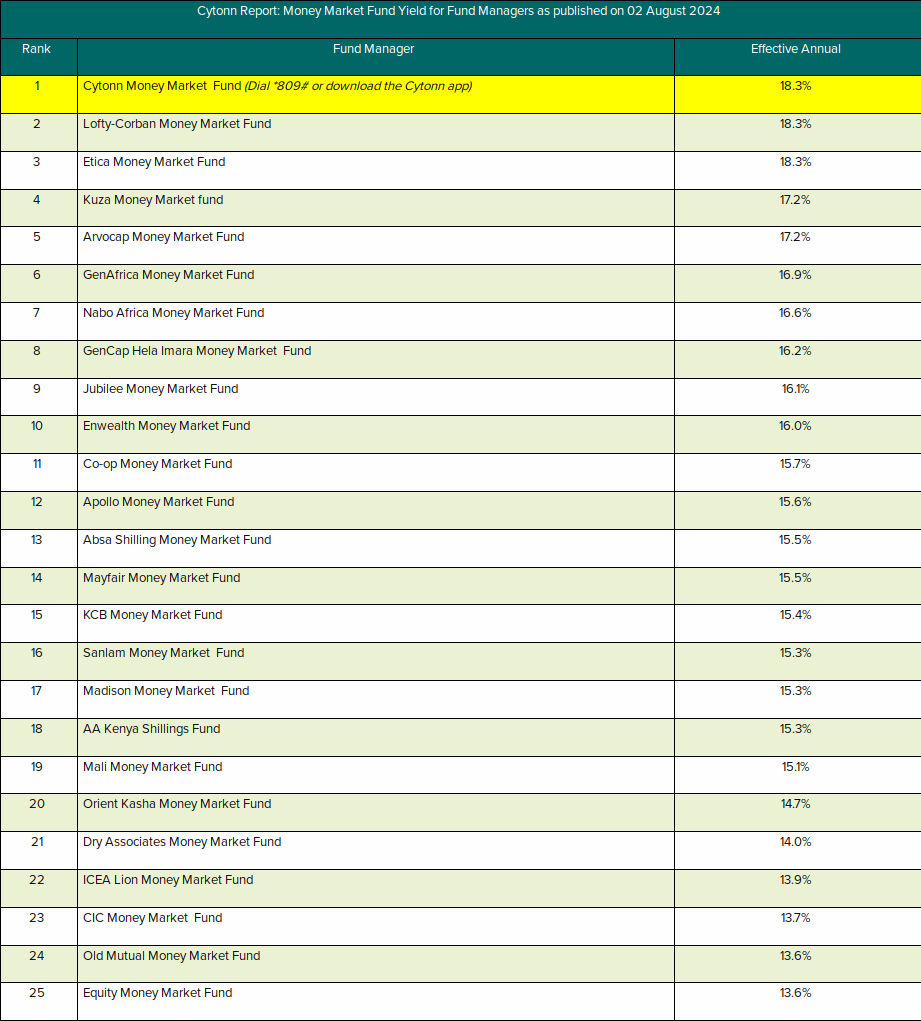

In [5]:
#| label: preview-image

async def yield_table_fn(page: Page):
    await page.waitForSelector('table')
    table_elements = await page.querySelectorAll('table')
    target_header_text = 'Cytonn Report: Money Market Fund Yield'
    for table_element in table_elements:
        table_headers = await table_element.querySelectorAll('thead tr td')
        for table_header in table_headers:
            header_text:str = await page.evaluate('(element) => element.textContent', table_header)
            if header_text.startswith(target_header_text):
                return table_element

await web_screenshot_async(
    "https://cytonnreport.com/research/cytonn-monthly-",
    action = yield_table_fn,
    width = 1000, 
    height = 2000,
    options=None)

#### Crawling

At <https://cytonn.com/researches>, we can crawl and parse HTML, but it could be very slow. We notice that <https://cytonnreport.com/research>, the exact same data is displayed, but using a background request, <https://cytonnreport.com/get/allreports>. We can use this to crawl multiple reports faster.

In [7]:
async def get_all_cytonn_reports(per_page_count: int = 10):
    """
    Retrieves all Cytonn reports from the Cytonn Report website.

    Args:
        per_page_count (int, optional): The number of reports to retrieve per page. Defaults to 10.

    Returns:
        list: A list of all the retrieved reports.
    """
    ...
    page, browser = await get_browser_page_async()
    reports_url = "https://cytonnreport.com/get/allreports"
    reports_headers: dict = None
    reports_method: str = None
    async def catch_request(request: Request):
        nonlocal reports_headers
        nonlocal reports_method
        if request.url == reports_url:
            reports_headers = request.headers.copy()
            reports_method = request.method
            await request.continue_()
        else:
            await request.continue_()
    async def get_cytonn_reports(current_page: int):
        javascript_fetch_fn = f'''
            async () => {{
                try {{
                    const response = await fetch(
                        "{reports_url}", 
                        {{
                            "headers": {json.dumps(reports_headers)},
                            "method": "{reports_method}",
                            "body": {json.dumps(json.dumps(
                                {
                                    "pagination": {
                                        "per_page": per_page_count, 
                                        "current_page": current_page
                                    }
                                }))},
                            "referrer": "https://cytonnreport.com/research",
                            "referrerPolicy": "no-referrer-when-downgrade",
                            "mode": "cors",
                            "credentials": "include"
                        }});
                    if (!response.ok) {{
                        throw new Error(`HTTP error! status: ${{response.status}}`);
                    }}
                    const json = await response.json();
                    return json;
                }} catch (error) {{
                    console.error('Fetch error:', error);
                    throw error; // Re-throw to allow calling code to handle it
                }}
            }}
        '''
        response_json = await page.evaluate(javascript_fetch_fn)
        return response_json
    # Enable request interception
    await page.setRequestInterception(True)
    # Attach the request handler
    page.on('request', lambda request: asyncio.ensure_future(catch_request(request)))
    # Navigate to the desired URL
    await page.goto("https://cytonnreport.com/research")
    while not reports_headers:
        await asyncio.sleep(1)
    current_page = 1
    all_reports = []
    pbar: tqdm = None
    while True:
        reports_response = await get_cytonn_reports(current_page)
        reports = reports_response['data'] if reports_response else []
        if len(reports) > 0:
            total = reports_response['total']
            pbar = pbar or tqdm(total=total)
            pbar.update(len(reports))
            all_reports.extend(reports)
            last_page = reports_response['last_page']
            if last_page == current_page:
                break
            current_page += 1
        else:
            break
        await asyncio.sleep(0.4)
    await browser.close()
    if pbar:
        pbar.close()
    return all_reports

all_cytonn_reports = await get_all_cytonn_reports()
print(f'There are {len(all_cytonn_reports)} reports')

650it [01:34,  6.87it/s]                         

There are 650 reports


In [17]:
# converting the JSON into dataframe
all_cytonn_reports_df = pd.DataFrame(all_cytonn_reports)
with pd.option_context(
  'display.max_columns', None, 
  'display.max_colwidth', 100):
  display(all_cytonn_reports_df)

,id,slug,name,author,researchdate,active,created_by,series_id,campaign,sent,thumbnail,created_at,meta_title,meta_keywords,meta_description,og_description,url,og_image,updated_at,deleted_at,title,category,summary,body,date_holder,date,creator,status,series,topics
0,725,cytonn-monthly-,Cytonn Monthly – July 2024,Investments Team,2024-08-04,1,95,1,2344,1,None,2024-08-04 13:12:49,None,None,None,None,https://cytonnreport.com/research/cytonn-monthly-,https://cytonnreport.com/storage/research/tmpphpzcyorm66af5421e0a3f2.40294162.png,2024-08-04 14:39:52,None,Cytonn Monthly – July 2024,Investment Reports,"<p><strong>Money Markets, T-Bills Primary Auction: </strong></p>\r\n<p>During the month of July ...","<p><strong>Money Markets, T-Bills Primary Auction: </strong></p>\r\n<p>During the month of July ...",4,"4 August, 2024",Fredrick Maore,Active,"{'id': 1, 'name': 'Cytonn Weekly', 'description': '<p>A report given by Cytonn every week</p>', ...","[{'id': 2428, 'name': 'Fixed Income', 'slug': 'fixed-income', 'title': None, 'summary': '<p>Duri..."
1,723,review-of-kenyas,"Review of Kenya’s Public Debt 2024, & Cytonn Weekly #30/2024",Research Team,2024-07-28,1,93,3,2326,1,None,2024-07-28 16:01:55,None,None,None,None,https://cytonnreport.com/research/review-of-kenyas,https://cytonnreport.com/storage/research/tmpphplckz2v66a65e73cf3b98.67186864.jpg,2024-07-28 18:33:12,None,"Review of Kenya’s Public Debt 2024, & Cytonn Weekly #30/2024",Investment Reports,"<p><strong>Money Markets, T-Bills Primary Auction: </strong></p>\r\n<p>During the week, T-bills ...","<p><strong>Money Markets, T-Bills Primary Auction: </strong></p>\r\n<p>During the week, T-bills ...",28,"28 July, 2024",Erick Kariuki,Active,"{'id': 3, 'name': 'MPC Notes', 'description': '<p>Monetary Policy Committee Notes</p>', 'thumbna...","[{'id': 2422, 'name': 'Fixed Income', 'slug': 'fixed-income', 'title': None, 'summary': '<p>Duri..."
2,722,kenya-retail-report,"Kenya Retail Report 2024, & Cytonn Weekly #29/2024",Research team,2024-07-21,1,94,1,2317,1,None,2024-07-21 13:58:09,None,None,None,None,https://cytonnreport.com/research/kenya-retail-report,https://cytonnreport.com/storage/research/tmpphp0lrwri669cfbcfe16e17.91602814.jpg,2024-07-21 15:28:41,None,"Kenya Retail Report 2024, & Cytonn Weekly #29/2024",Investment Reports,"<p><strong>Money Markets, T-Bills Primary Auction: </strong></p>\r\n<p>During the week, T-bills ...","<p><strong>Money Markets, T-Bills Primary Auction: </strong></p>\r\n<p>During the week, T-bills ...",21,"21 July, 2024",Chelsea Nyakundi,Active,"{'id': 1, 'name': 'Cytonn Weekly', 'description': '<p>A report given by Cytonn every week</p>', ...","[{'id': 2417, 'name': 'Fixed Income', 'slug': 'fixed-income', 'title': None, 'summary': '<p><a n..."
3,721,special-interest-group,"Special Interest Group Funds in Kenya, & Cytonn Weekly #28/2024",Research Team,2024-07-14,1,97,1,2308,1,None,2024-07-14 15:49:28,None,None,None,None,https://cytonnreport.com/research/special-interest-group,https://cytonnreport.com/storage/research/tmpphphimr5s6693da00d73da2.45160926.jpg,2024-07-14 17:00:32,None,"Special Interest Group Funds in Kenya, & Cytonn Weekly #28/2024",Investment Reports,<p><strong>Investment Updates:</strong></p>\r\n<ul>\r\n<li>Weekly Rates:</li>\r\n<ul>\r\n<li>Cyt...,<p><strong>Investment Updates:</strong></p>\r\n<ul>\r\n<li>Weekly Rates:</li>\r\n<ul>\r\n<li>Cyt...,14,"14 July, 2024",Ian Kaire,Active,"{'id': 1, 'name': 'Cytonn Weekly', 'description': '<p>A report given by Cytonn every week</p>', ...","[{'id': 2412, 'name': 'Company updates', 'slug': 'company-updates', 'title': None, 'summary': No..."
4,720,kenyas-fy2024-2025-budget,"Kenya’s FY’2024/2025 Budget Review, & Cytonn Weekly #27/2024",Research Team,2024-07-07,1,95,1,2279,1,None,2024-07-07 13:38:10,None,None,None,None,https://cytonnreport.com/research/kenyas-fy2024-2025-budget,https://cytonnreport.com/storage/research/tmpphp07h656668a87ccb6e633.12520539.jfif,2024-07-07 15:19:24,None,"Kenya’s FY’2024/2025 Budget 

## Analysis

The objective of our analysis will be to answer the following questions:
 1. Are Money morkets Funds stable in Kenya?
 2. Which is the most cosistent Money Market Fund?
 3. How does the MMF compare to Inflation?
 4. How does the MMF compare to GDP?


<!-- 
1. Risk-adjusted returns: Analyze the Sharpe ratio or other risk-adjusted performance measures to understand which funds offer the best returns relative to their risk.

2. Correlation with other asset classes: Examine how MMFs correlate with other investment options like stocks, bonds, or real estate in Kenya.

3. Fund size and growth: Look at the trends in assets under management for different MMFs to see which ones are attracting more investors.

4. Expense ratios: Compare the fees charged by different MMFs and how they impact overall returns.

5. Liquidity analysis: Assess how quickly investors can withdraw their money and if there have been any instances of redemption freezes.

6. Sector allocation: Analyze the types of instruments MMFs are investing in (e.g., government securities, corporate paper) and how this affects performance.

7. Regulatory impact: Examine how changes in Kenyan financial regulations have affected MMF performance and stability over time.

8. Yield curve analysis: Study how MMF returns compare to the yield curve of government securities at different maturities.

9. Foreign vs. local currency funds: If applicable, compare the performance of MMFs that invest in foreign currency instruments to those that stick to local currency.

10. Economic indicators: Beyond GDP and inflation, you could look at how MMFs perform in relation to other economic indicators like interest rates, exchange rates, or monetary policy changes.

11. Investor demographics: Analyze who is investing in MMFs (e.g., institutional vs. retail investors) and how this might impact fund stability and performance.

12. Historical stress testing: Examine how Kenyan MMFs performed during past economic crises or market downturns. -->

### Exploratory Data Analysis

#### Summary of numerical columns

In [ ]:
all_cytonn_reports_df.describe()

#### Preview the Columns

In [ ]:
all_cytonn_reports_df.columns

In [49]:
all_cytonn_reports_df.iloc[0]

id                                                                725
slug                                                  cytonn-monthly-
name                                       Cytonn Monthly – July 2024
author                                               Investments Team
researchdate                                               2024-08-04
active                                                              1
created_by                                                         95
series_id                                                           1
campaign                                                         2344
sent                                                                1
thumbnail                                                        None
created_at                                        2024-08-04 13:12:49
meta_title                                                       None
meta_keywords                                                    None
meta_description    

#### Data types

In [ ]:
all_cytonn_reports_df.dtypes

Below is a tree structure of one record, to visualize the objects and their inner properties

In [18]:
print(json2txttree(all_cytonn_reports_df.loc[0,:].to_dict()))

└─  (object)
   ├─ "id" (number)
   ├─ "slug" (string)
   ├─ "name" (string)
   ├─ "author" (string)
   ├─ "researchdate" (string)
   ├─ "active" (number)
   ├─ "created_by" (number)
   ├─ "series_id" (number)
   ├─ "campaign" (string)
   ├─ "sent" (number)
   ├─ "thumbnail" (number)
   ├─ "created_at" (string)
   ├─ "meta_title" (number)
   ├─ "meta_keywords" (number)
   ├─ "meta_description" (number)
   ├─ "og_description" (number)
   ├─ "url" (string)
   ├─ "og_image" (string)
   ├─ "updated_at" (string)
   ├─ "deleted_at" (number)
   ├─ "title" (string)
   ├─ "category" (string)
   ├─ "summary" (string)
   ├─ "body" (string)
   ├─ "date_holder" (number)
   ├─ "date" (string)
   ├─ "creator" (string)
   ├─ "status" (string)
   ├─ "series" (object)
   │  ├─ "id" (number)
   │  ├─ "name" (string)
   │  ├─ "description" (string)
   │  ├─ "thumbnail" (string)
   │  ├─ "created_by" (number)
   │  ├─ "category_id" (number)
   │  ├─ "created_at" (string)
   │  ├─ "updated_at" (string)
   │

A full article is formed by articles. Each `topics` is a subsection, with `title` being the header and `body` being the content. We will merge all bodies from the articles to form the entire report HTML, which we will parse to extract the Money Market Funds yields tables. In addition, we are also going to add the main `body` and main `summary` and topics `summary` to encure we capture any table we might miss.

In [51]:
def get_report_HTML(index: int) -> str:
    """
    Retrieves the HTML content of a report based on the given index.

    Parameters:
    - index (int): The index of the report to retrieve.

    Returns:
    - str: The HTML content of the report.

    Raises:
    - KeyError: If the index is not found in the 'all_cytonn_reports_df' DataFrame.

    Example:
    >>> get_report_HTML(0)
    'Summary HTML \n Body HTML \n Topics HTML'
    """
    summary_html = all_cytonn_reports_df.loc[index, 'summary']
    body_html = all_cytonn_reports_df.loc[index, 'body']
    topics_html = ''.join([f"{i['summary']} \n\n {i['body']}" for i in all_cytonn_reports_df.loc[index, 'topics']])
    return f"{summary_html} \n {body_html} \n {topics_html}"

#### Grouping

In [ ]:
def parse_grouped_dates(date_string: str):
    pattern = r"^(FY|Q[1-4]|H[1-2])'(\d{4})$"
    match = re.match(pattern, date_string, re.IGNORECASE)
    if not match:
        return None
    period, year = match.groups()
    year = int(year)
    if period.upper() == 'FY':
        start_date = datetime(year, 1, 1)
        end_date = datetime(year, 12, 31)
    elif period.upper().startswith('Q'):
        quarter = int(period[1])
        start_month = (quarter - 1) * 3 + 1
        start_date = datetime(year, start_month, 1)
        end_date = start_date.replace(month=start_month + 2) + timedelta(days=32)
        end_date = end_date.replace(day=1) - timedelta(days=1)
    elif period.upper().startswith('H'):
        half = int(period[1])
        start_month = (half - 1) * 6 + 1
        start_date = datetime(year, start_month, 1)
        end_date = start_date.replace(month=start_month + 5) + timedelta(days=32)
        end_date = end_date.replace(day=1) - timedelta(days=1)
    return (start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))

# Test the function
test_dates = ["FY'2019", "Q1'2020", "H1'2019", "fy'2018", "q3'2021", "h2'2022"]

for expanding_value in test_dates:
    result = parse_grouped_dates(expanding_value)
    if result:
        print(f"{expanding_value}: {result}")
    else:
        print(f"{expanding_value}: Invalid format")

In [ ]:
fund_manager_maps = [
    # (['etica'], 'Etica Capital Limited'),
    # (['lofty-corban'], 'Lofty-Corban Investments Limited'),
    # (['genafrica'], 'GenAfrica Asset Managers Limited'),
    # (['nabo'], 'Nabo Capital Limited'),
    # (['cytonn'], 'Cytonn Asset Managers Limited'),
    # (['apollo'], 'Apollo Asset Management Company Limited'),
    # (['kuza'], 'Kuza Asset Management Limited'),
    # (['enwealth'], 'Enwealth Money Market Fund'),
    # (['madison'], 'Madison Investment Managers Limited'),
    # (['co-op'], 'Co-op Trust Investment Services Limited'),
    # (['sanlam'], 'Sanlam Investments East Africa Limited'),
    # (['gencap', 'imara'], 'GenCap Hela Imara Money Market Fund'),
    # (['mayfair'], 'Mayfair Asset Managers Limited'),
    # (['aa'], 'AA kenya shillings fund'),
    # (['jubilee'], 'Jubilee Financial Services Limited'),
    # (['orient', 'kasha', 'alpha', 'alphafrica'], 'Orient Asset Managers Limited'), # 'Alpha Africa Asset Managers'
    # (['mutual', 'old'], 'Old Mutual Investment Group'),
    # (['absa'], 'ABSA Asset Management Limited'),
    # (['dry'], 'Dry Associates Money Market Fund'),
    # (['kcb', 'natbank'], 'KCB Asset Management Limited (formerly Natbank Trustee and Investment Services Limited)'),
    # (['cic'], 'CIC Asset Managers Limited'),
    # (['icea'], 'ICEA Asset Lion Asset Management Limited'),
    # (['equity'], 'Equity money market fund'),
    # (['mali'], 'Mali Money Market Fund'),
    # (['britam', 'british-american', 'british', 'american'], 'Britam Asset Managers (Kenya) Limited'),
    # (['zimele'], 'Zimele Asset Management Company Limited'),
    # (['ncba'], 'NCBA Unit Trust Scheme'),
    # (['genghis'], 'Genghis Unit Trust Fund'),
    # (['commercial'], 'Commercial Bank of Africa'),
    # (['alliance'], 'African Alliance Kenya'),
    # (['stanlib'], 'Stanlib Kenya'),
    # (['amana'], 'Amana Capital Limited'),
    # # (['alpha', 'alphafrica'], 'Alpha Africa Asset Managers'),
    # (['arvocap'], 'Arvocap Money Market Fund'),
    # (['madisson'], 'Madisson Money Market Fund'),
    # (['wanafunzi'], 'Wanafunzi Investments')
    (['orient', 'kasha', 'alpha', 'alphafrica'], 'Orient Asset Managers Limited'),
    (['amana'], 'Amana Capital Limited'),
    (['apollo'], 'Apollo Asset Management Company Limited'),
    (['britam', 'british-american', 'british', 'american'], 'Britam Asset Managers (Kenya) Limited'),
    (['metropolitan'], 'Metropolitan Canon Asset Managers Limited'),
    (['nabo'], 'Nabo Capital Limited'),
    (['cic'], 'CIC Asset Managers Limited'),
    (['co-op'], 'Co-op Trust Investment Services Limited'),
    (['fcb'], 'FCB Capital Limited'),
    (['fusion'], 'Fusion Investment Management Limited'),
    (['genafrica'], 'GenAfrica Asset Managers Limited'),
    (['icea'], 'ICEA Asset Lion Asset Management Limited'),
    (['madison'], 'Madison Investment Managers Limited'),
    (['mutual', 'old'], 'Old Mutual Investment Group'),
    (['sanlam'], 'Sanlam Investments East Africa Limited'),
    (['standard'], 'Standard Chartered Investment Services Limited'),
    (['zimele'], 'Zimele Asset Management Company Limited'),
    (['kcb', 'natbank'], 'KCB Asset Management Limited'), # (formerly Natbank Trustee and Investment Services Limited)
    (['cytonn'], 'Cytonn Asset Managers Limited'),
    (['altree'], 'Altree Capital Kenya Limited'),
    (['jubilee'], 'Jubilee Financial Services Limited'),
    (['absa'], 'ABSA Asset Management Limited'),
    (['african'], 'African Diaspora Asset Managers Limited'),
    (['cfs'], 'CFS Asset Management Limited'),
    (['i&m'], 'I&M Capital Limited'),
    (['globetec'], 'Globetec Asset Managers Limited'),
    (['african'], 'African Alliance Kenya Asset Management Limited'),
    (['cpf'], 'CPF Financial Services Limited'),
    (['kuza'], 'Kuza Asset Management Limited'),
    (['waanzilishi'], 'Waanzilishi Capital Limited'),
    (['mayfair'], 'Mayfair Asset Managers Limited'),
    (['etica'], 'Etica Capital Limited'),
    (['star'], 'Star Capital Management Limited'),
    (['lofty-corban'], 'Lofty-Corban Investments Limited')
]
fund_manager_maps

In [ ]:
non_existent_fund_manager_maps = []
invalids = []
class RecordInfo:
    TYPE_AUM: str = 'AUM' # 'AUM' - Assets Under Management
    TYPE_EAR: str = 'EAR' # 'EAR' - Effective Annual Rate
    def __init__(self, record_type: str, record_date: str, record_value: str, fund_manager: str):
        self.record_type = RecordInfo.__validate_record_type(record_type)
        self.record_date = parse_grouped_dates(record_date) or datetime.strptime(record_date, "%Y-%m-%d").strftime('%Y-%m-%d') or None
        self.record_value = RecordInfo.__validate_record_value(record_value)
        self.fund_manager = RecordInfo.__validate_fund_manager(fund_manager)
    def is_valid(self) -> bool:
        is_valid = bool(self.record_type) and bool(self.record_date) and bool(self.record_value) and bool(self.fund_manager)
        return is_valid
    @staticmethod
    def __validate_fund_manager(value: str) -> str|None:
        value = str(value or '').lower()
        excludes = ['Dollar', 'USD']
        if not any((exclude.lower() in value) for exclude in excludes):
            names = [j for i, j in fund_manager_maps if any(k in value for k in i)]
            if len(names) == 1:
                return names[0]
        non_existent_fund_manager_maps.append(value)
        return None
    @staticmethod
    def __validate_record_value(value: str|float) -> str|None:
        if type(value) == float:
            return value
        # remove percentage sign
        value = value.rstrip('%')
        # remove comma and white space
        value = ''.join([i for i in value if i not in [' ', ',', '-']])
        return float(value) if value else None
    @staticmethod
    def __validate_record_type(value: str) -> str|None:
        value = value.upper()
        return value if value in [RecordInfo.TYPE_AUM, RecordInfo.TYPE_EAR] else None

# some pages have more than one table, ge: https://cytonnreport.com/research/unit-trust-fund-performance-q3-1
table_columns_list: list[tuple[list[str], list[Callable[[pd.Series, dict], RecordInfo]]]] = [
    (
        ['Rank', 'Fund Manager', 'Effective Annual Rate'], 
        [
            # https://cytonnreport.com/research/kenyas-fy2024-2025-budget
            # https://cytonnreport.com/research/nairobi-metropolitan-area-serviced-apartments-report-2021
            lambda row, record: RecordInfo(
                RecordInfo.TYPE_EAR, record['researchdate'], row['Effective Annual Rate'], row['Fund Manager'])
        ]
    ),
    (
        ['Rank', 'Fund Manager', 'Effective Annual'], 
        [
            # https://cytonnreport.com/research/cytonn-monthly-may-2024
            # https://cytonnreport.com/research/q12023-unit-trust-funds-performance-cytonn-monthly-july-2023
            lambda row, record: RecordInfo(
                RecordInfo.TYPE_EAR, record['researchdate'], row['Effective Annual'], row['Fund Manager'])
        ]
    ),
    (
        ['Rank', 'Fund Manager', 'Daily Yield', 'Effective Annual Rate'], 
        [
            # Effective Annual Rate is better than Daily Yield: https://cytonnreport.com/research/cytonn-monthly-october-2021
            # https://cytonnreport.com/research/potential-effects-covid-19
            lambda row, record: RecordInfo(
                RecordInfo.TYPE_EAR, record['researchdate'], row['Effective Annual Rate'], row['Fund Manager']),
        ]
    ),
    (
        [ 
            'no.', 'fund-managers', 'q1’2020-aum(kshs-mns)', 'q1’2020market-share', 'q2’2020-aum(kshs-mns)', 
            'q2’2020market-share', 'aum-growthq1’2020-–-q2’2020'], 
        [
            # https://cytonnreport.com/research/unit-trust-funds-performance-q2-2020
            lambda row, _: RecordInfo(
                RecordInfo.TYPE_AUM, "Q1'2020", row['q1’2020-aum(kshs-mns)'], row['fund-managers']),
            lambda row, _: RecordInfo(
                RecordInfo.TYPE_AUM, "Q2'2020", row['q2’2020-aum(kshs-mns)'], row['fund-managers']),
        ]
    ),
    (
        ['no.', 'fund-managers', "fy'2019-aum(kshs-mns)", 'q1’2020-aum(kshs-mns)', "aum-growth*fy'2019-–-q1’2020"], 
        [
            # https://cytonnreport.com/research/unit-trust-funds-perfomance-q1-2020-cytonn-weekly
            lambda row, _: RecordInfo(
                RecordInfo.TYPE_AUM, "FY'2019", row["fy'2019-aum(kshs-mns)"], row['fund-managers']),
            lambda row, _: RecordInfo(
                RecordInfo.TYPE_AUM, "Q1'2020", row['q1’2020-aum(kshs-mns)'], row['fund-managers']),
        ]
    ),
    (
        ['no.', 'fund-managers', "fy'2018-aum-(kshs-mns)", "h1'2019-aum-(kshs-mns)", "aum-h1'2019-annualized-growth"], 
        [
            # https://cytonnreport.com/research/unit-trust-funds-performance
            lambda row, _: RecordInfo(
                RecordInfo.TYPE_AUM, "FY'2018", row["fy'2018-aum-(kshs-mns)"], row['fund-managers']),
            lambda row, _: RecordInfo(
                RecordInfo.TYPE_AUM, "H1'2019", row["h1'2019-aum-(kshs-mns)"], row['fund-managers']),
        ]
    ),
    (
        ['no.', 'money-market-fund', '2018-average-effective-annual-yield-p.a.'], 
        [
            # https://cytonnreport.com/research/investing-in-unit
            lambda row, record: RecordInfo(
                RecordInfo.TYPE_EAR, record['researchdate'], row['2018-average-effective-annual-yield-p.a.'], 
                row['money-market-fund'])
        ]
    ),
    (
        ['no.', 'fund-managers', 'q2’2020-aum', 'q2’2020', 'q3’2020-aum', 'q3’2020', 'aum-growth'], 
        [
            # https://cytonnreport.com/research/unit-trust-fund-performance-q3-1
            lambda row, _: RecordInfo(RecordInfo.TYPE_AUM, "Q2'2020", row['q2’2020-aum'], row['fund-managers']),
            lambda row, _: RecordInfo(RecordInfo.TYPE_AUM, "Q3'2020", row['q3’2020-aum'], row['fund-managers'])
        ]
    ),
    (
        ['rank', 'money-market-funds', 'effective-annual-rate-(average-q3’2020)'], 
        [
            # https://cytonnreport.com/research/unit-trust-fund-performance-q3-1
            lambda row, record: RecordInfo(
                RecordInfo.TYPE_EAR, record['researchdate'], row['effective-annual-rate-(average-q3’2020)'], 
                row['money-market-funds'])
        ]
    ),
    (
        ['no.', 'fund-managers', "fy'2018-aum(kshs-mns)", "fy'2019-aum(kshs-mns)", "aum-growthfy'2018---fy'2019"], 
        [
            # https://cytonnreport.com/research/fy2019-utf-performance
            lambda row, _: RecordInfo(RecordInfo.TYPE_AUM, "FY'2018", row["fy'2018-aum(kshs-mns)"], row['fund-managers']),
            lambda row, _: RecordInfo(RecordInfo.TYPE_AUM, "FY'2019", row["fy'2019-aum(kshs-mns)"], row['fund-managers']),
        ]
    ),
    (
        [
            'no.', 'fund-managers', "fy'2018-money-market-fund(kshs-mns)", "fy'2019-money-market-fund(kshs-mns)", 
            "fy'2018-market-share", "fy'2019-market-share", 'variance'
        ], 
        [
            # https://cytonnreport.com/research/fy2019-utf-performance
            lambda row, _: RecordInfo(
                RecordInfo.TYPE_AUM, "FY'2018", row["fy'2018-money-market-fund(kshs-mns)"], row['fund-managers']),
            lambda row, _: RecordInfo(
                RecordInfo.TYPE_AUM, "FY'2019", row["fy'2019-money-market-fund(kshs-mns)"], row['fund-managers']),
        ]
    ),
    (
        ['rank', 'money-market-funds', 'effective-annual-rate-(average-fy’2019)'], 
        [
            # https://cytonnreport.com/research/fy2019-utf-performance
            lambda row, record: RecordInfo(
                RecordInfo.TYPE_EAR, record['researchdate'], row['effective-annual-rate-(average-fy’2019)'], 
                row['money-market-funds']),
        ]
    ),
    (
        ['no.', 'unit-trust-fund-manager', 'aum', '%-of-market-share'], 
        [
            # https://cytonnreport.com/research/investment-options-in-kenyan-market
            lambda row, record: RecordInfo(
                RecordInfo.TYPE_AUM, record['researchdate'], row['aum'], row['unit-trust-fund-manager']),
        ]
    ),
    (
        [
            'no.', 'fund-managers', "h1'2018-money-market-fund(kshs-mn)", 'fy’2018-money-market-fund-(kshs-mn)', 
            "h1'2019-money-market-fund(kshs-mn)", "annualized-h1'2019-growth"
        ], 
        [
            # https://cytonnreport.com/research/options-for-your-pension
            lambda row, _: RecordInfo(
                RecordInfo.TYPE_AUM, "H1'2018", row["h1'2018-money-market-fund(kshs-mn)"], row['fund-managers']),
            lambda row, _: RecordInfo(
                RecordInfo.TYPE_AUM, "FY'2018", row['fy’2018-money-market-fund-(kshs-mn)'], row['fund-managers']),
            lambda row, _: RecordInfo(
                RecordInfo.TYPE_AUM, "H1'2019", row["h1'2019-money-market-fund(kshs-mn)"], row['fund-managers']),
        ]
    ),
    (
        [
            '#', 'fund-managers', "h1'2018-money-market-fund-aum-(kshs-mn)", "fy'2018-money-market-fund-aum(kshs-mn)", 
            "h1'2019-money-market-fund-aum(kshs-mn)", "annualized-h1'2019-aum-growth"
        ], 
        [
            # https://cytonnreport.com/research/cytonn-monthly-august-2019
            lambda row, _: RecordInfo(
                RecordInfo.TYPE_AUM, "H1'2018", row["h1'2018-money-market-fund-aum-(kshs-mn)"], row['fund-managers']),
            lambda row, _: RecordInfo(
                RecordInfo.TYPE_AUM, "FY'2018", row["fy'2018-money-market-fund-aum(kshs-mn)"], row['fund-managers']),
            lambda row, _: RecordInfo(
                RecordInfo.TYPE_AUM, "H1'2019", row["h1'2019-money-market-fund-aum(kshs-mn)"], row['fund-managers']),
        ]
    ),
    (
        [ 'No.', 'Collective Investment Schemes', "FY’2023 AUM", "FY’2023", "Q1'2024 AUM", "Q1’2024", 'AUM Growth'], 
        [
            # https://cytonnreport.com/research/q1-2024-unit-trust-funds-performance-note
            lambda row, _: RecordInfo(
                RecordInfo.TYPE_AUM, "FY'2023", row["FY’2023 AUM"], row['Collective Investment Schemes']),
            lambda row, _: RecordInfo(
                RecordInfo.TYPE_AUM, "Q1'2024", row["Q1'2024 AUM"], row['Collective Investment Schemes'])
        ]
    ),
]

def column_name_match_fn(x: str, y:str) -> bool:
    x = x.strip().lower()
    y = y.strip().lower()
    z = lambda val: re.sub(r'\s+', ' ', val).replace(" ", "-")
    return x == y or z(x) == z(y)

def get_table(table: Tag):
    for tag in table.find_all(True):
        tag.attrs = {} # remove tags such as colspan and rowspan
    for (table_columns, extractor_callbacks) in table_columns_list:
        clean_up_tasks: list[Callable[[], None]] = []
        header_tr_s: list[Tag] = table.select('thead tr')
        is_match = False
        for header_tr in header_tr_s:
            header_td_s: list[Tag] = header_tr.find_all('td')
            is_match_new = \
                len(header_td_s) == len(table_columns)\
                and all(
                    [column_name_match_fn(header_td.get_text(strip=True), table_column) 
                     for header_td, table_column 
                     in zip(header_td_s, table_columns)])
            if not is_match_new:
                clean_up_tasks.append(header_tr.extract)
            is_match = is_match or is_match_new
        if is_match:
            try:
                [clean_up_task() for clean_up_task in clean_up_tasks]
                table_df = pd.read_html(io.StringIO(str(table)))[0]
                table_df.columns = table_columns
                return (table_df, extractor_callbacks)
            except Exception as e:
                print('error', e, table)
                continue
    return (None, None)

def is_valid_dataframe(df: pd.DataFrame | None) -> bool:
    return df is not None and not df.empty

def get_tables(html: str):
    parsed_html = BeautifulSoup(html, "html.parser")
    tables: list[Tag] = [table for table in parsed_html.find_all('table')]
    for table in tables:
        table_df, extractor_callbacks = get_table(copy(table))
        if is_valid_dataframe(table_df):
            yield (table_df, extractor_callbacks)

def extract_table_by_column_names(record: pd.Series):
    topics: list[dict] = record['topics']
    all_topic_bodies = ' '.join([topic.get('body') for topic in topics])
    raw_tables__extractor_callbacks = get_tables(all_topic_bodies)
    for raw_table, extractor_callbacks in raw_tables__extractor_callbacks:
        if len(extractor_callbacks) > 0:
            for callback in extractor_callbacks:
                extracted: list[tuple[RecordInfo, pd.Series]] = [(callback(raw_table_row, record), raw_table_row) for _,raw_table_row in raw_table.iterrows()]
                _invalids = [i for i in extracted if not i[0].is_valid()]
                if len(_invalids) > 0:
                    invalids.append((record, _invalids, raw_table))
                yield raw_table, pd.DataFrame([vars(i) for i, _ in extracted if i.is_valid()])
        else:
            yield raw_table, None

In [ ]:
non_existent_fund_manager_maps

In [ ]:
invalids

#### Saving

In [ ]:
table_paths = 'extracted_tables'
os.makedirs(table_paths, exist_ok=True)
for _, record in tqdm(all_cytonn_reports_df.iterrows(), total=len(all_cytonn_reports_df)):
    raw_and_extracted_dataframes = extract_table_by_column_names(record)
    for _, extracted_df in raw_and_extracted_dataframes:
        if is_valid_dataframe(extracted_df):
            extracted_df.to_json(f'extracted_tables/{record.id}.json', orient='records')

#### Testing for Valid

In [ ]:
good = [i for i in non_existent_fund_manager_maps if not any([(j in i) for j in ['total', 'average', 'nan']])]
len(good), good

In [ ]:
# pd.set_option('display.max_colwidth', None)
with pd.option_context(
  'display.max_columns', None, 
  'display.max_colwidth', None):
  display(pd.DataFrame([{**vars(i), "row": j} for i, j, in invalids[0][1]]))

<hr/>

In [ ]:
from glob import glob

dataframes = []
for filename in  glob(f'extracted_tables/*.json'):
    json_df = pd.read_json(filename)
    dataframes.append(json_df)
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df

In [ ]:
def expand_date_column(df: pd.DataFrame, expand_column: str):
    for _, row in df.iterrows():
        expanding_values = row[expand_column]
        if type(expanding_values) == list:
            start_date = datetime.strptime(expanding_values[0], "%Y-%m-%d")
            end_date = datetime.strptime(expanding_values[1], "%Y-%m-%d")
            start_end_diff_days = (end_date - start_date).days
            day_list = [
                (start_date + timedelta(days=i)).strftime('%Y-%m-%d') 
                for i 
                in range(start_end_diff_days + 1)
            ]
            for day in day_list:
                yield { **row.to_dict(), expand_column: day }
        else:
            yield row.to_dict()

combined_df = pd.DataFrame(expand_date_column(combined_df, 'record_date'))
combined_df

In [ ]:
grouped_df = combined_df.groupby(
    ['record_type', 'record_date', 'fund_manager'])['record_value'].mean().reset_index()
grouped_df

In [ ]:
EAR_df = grouped_df[grouped_df['record_type'] == 'EAR'].drop(columns=['record_type']).copy()
EAR_df['record_date'] = pd.to_datetime(EAR_df['record_date'])
EAR_pivot = EAR_df.pivot(index='record_date', columns='fund_manager', values='record_value')
EAR_pivot

In [ ]:
EAR_fig = px.line(EAR_pivot, x=EAR_pivot.index, y=EAR_pivot.columns)
EAR_fig.update_layout(
    height=800,
    margin=dict(t=100),
    title=dict(
        text="Effective Annual Rate",  # Your title here
        y=0.98,                   # Adjust the title's vertical position
        x=0.5,                    # Center the title
        xanchor='center',
        yanchor='top'
    ),
    xaxis=dict(
        side="top",    # This moves the x-axis to the top
        title="Date"   # This sets the title for the x-axis
    ),
    yaxis=dict(
        title="Effective Annual Rate"   # This sets the title for the x-axis
    ),

    legend=dict(
        orientation="h",  # horizontal orientation
        yanchor="bottom",
        y=-4.5,  # move the legend below the plot
        xanchor="center",
        x=0.5
    ))
EAR_fig.update_traces(
    hovertemplate="<br>".join([
        "fund_manager=%{fullData.name}",
        "date=%{x|%Y-%m-%d}",
        "annual_rate=%{y}%",
        # removes any additional trace information that Plotly might add by default.
        "<extra></extra>"
    ])
)
EAR_fig.show()

In [ ]:
start_date = '2022-09-01'
end_date = '2022-09-30'

# Filter the DataFrame
filtered_df = all_cytonn_reports_df[
    (pd.to_datetime(all_cytonn_reports_df['researchdate']) >= start_date) & \
    (pd.to_datetime(all_cytonn_reports_df['researchdate']) <= end_date)
]
list(filtered_df.loc[:,'url'])

In [ ]:
all_cytonn_reports_df

<hr/>

In [ ]:
AUM_df = grouped_df[grouped_df['record_type'] == 'AUM'].drop(columns=['record_type']).copy()
AUM_df['record_date'] = pd.to_datetime(AUM_df['record_date'])
AUM_pivot = AUM_df.pivot(index='record_date', columns='fund_manager', values='record_value')
AUM_pivot

In [ ]:
AUM_fig = px.line(AUM_pivot, x=AUM_pivot.index, y=AUM_pivot.columns)
AUM_fig.update_layout(
    height=800,
    margin=dict(t=100),
    title=dict(
        text="Assets Under Management",  # Your title here
        y=0.98,                   # Adjust the title's vertical position
        x=0.5,                    # Center the title
        xanchor='center',
        yanchor='top'
    ),
    xaxis=dict(
        side="top",    # This moves the x-axis to the top
        title="Date"   # This sets the title for the x-axis
    ),
    yaxis=dict(
        title="Assets Under Management"   # This sets the title for the x-axis
    ),

    legend=dict(
        orientation="h",  # horizontal orientation
        yanchor="bottom",
        y=-4.5,  # move the legend below the plot
        xanchor="center",
        x=0.5
    ))
AUM_fig.update_traces(
    hovertemplate="<br>".join([
        "fund_manager=%{fullData.name}",
        "date=%{x|%Y-%m-%d}",
        "annual_rate=%{y}%",
        # removes any additional trace information that Plotly might add by default.
        "<extra></extra>"
    ])
)
AUM_fig.show()

<hr/>

In [ ]:
def topics_tables_predicate(row: pd.Series):
    html = ' '.join([topic.get('body') for topic in row['topics']])
    parsed_html = BeautifulSoup(html, "html.parser")
    tables: list[Tag] = [table for table in parsed_html.find_all('table')]
    tables_str_value = ' '.join(str(table) for table in tables).lower()
    unwanted_regexes = ['cic\s*group', 'cic\s*insurance', 'cic\s*academia']
    for unwanted_regex in unwanted_regexes:
        tables_str_value = re.sub(unwanted_regex, "", tables_str_value, flags=re.IGNORECASE)
    return 'cic' in tables_str_value

matched_records = []
for index, record in tqdm(all_cytonn_reports_df.iterrows(), total=len(all_cytonn_reports_df)):
    raw_and_extracted_dataframes = extract_table_by_column_names(record)
    extracts = list(raw_and_extracted_dataframes)
    is_topics_match = topics_tables_predicate(record)
    matched_records.append((index, len(extracts), is_topics_match))

In [ ]:
indexes_with_cic = [index for index, tables, is_topics_match in matched_records if tables == 0 and is_topics_match]
indexes_with_cic

<hr/>

In [ ]:
len(indexes_with_cic)

In [ ]:
webbrowser.get("/usr/bin/google-chrome %s")
for index in indexes_with_cic[20:]:
    url = str(all_cytonn_reports_df.loc[index, 'url'])
    webbrowser.open(url)

In [ ]:
row = all_cytonn_reports_df.loc[
    all_cytonn_reports_df['url'] == 'https://cytonnreport.com/research/unit-trust-fund-performance-q3-1'
].iloc[0]
dfs = extract_table_by_column_names(row)

In [ ]:
dfs[0]

<hr/>

In [ ]:
row = all_cytonn_reports_df.loc[
    all_cytonn_reports_df['url'] == 'https://cytonnreport.com/research/q1-2024-unit-trust-funds-performance-note'
].iloc[0]
table_columns_list = [
    (
        [ 'No.', 'Collective Investment Schemes', "FY’2023 AUM", "FY’2023", "Q1'2024 AUM", "Q1’2024", 'AUM Growth'], 
        [
            # https://cytonnreport.com/research/q1-2024-unit-trust-funds-performance-note
            lambda row, _: RecordInfo("AUM", 'FY’2023', row["FY’2023 AUM"], row['Collective Investment Schemes']),
            lambda row, _: RecordInfo("AUM", 'Q1’2024', row["Q1'2024 AUM"], row['Collective Investment Schemes'])
        ]
    ),
]
dfs = extract_table_by_column_names(row)

In [ ]:
one = next(dfs)

In [ ]:
one[1] 

## Achrives

To ensure perpetuity and reproducibility of this analysis, the crawled [Cytton Reports](https://huggingface.co/datasets/ToKnow-ai/money-market-funds-in-kenya__july-2024-archive/viewer/cytonn_reports) and [Capital Markets Authority Approved Fund Managers](https://huggingface.co/datasets/ToKnow-ai/money-market-funds-in-kenya__july-2024-archive/viewer/cma_approved_fund_managers) has been archived at <https://huggingface.co/datasets/ToKnow-ai/money-market-funds-in-kenya__july-2024-archive>.

In [ ]:
#|output: false

from python_utils.upload_dataset import upload_dataframe_to_huggingface

repo_id = "ToKnow-ai/unit-trust-investments-in-kenya-money-market-funds"

# upload_dataframe_to_huggingface(
#     fund_managers_df, 
#     repo_id=repo_id, 
#     dataset_name="C.M.A Approved Fund Managers", 
#     split="data")

# upload_dataframe_to_huggingface(
#     fuller_fund_managers_df, 
#     repo_id=repo_id, 
#     dataset_name="Detailed C.M.A Approved Fund Managers", 
#     split="data")

# upload_dataframe_to_huggingface(
#     all_cytonn_reports_df, 
#     repo_id=repo_id, 
#     dataset_name="Cytonn Reports", 
#     split="data")

<!-- #| .content-visible when-format: "html" -->

### CMA Approved Fund Managers

{{< iframe 
  'Loading Approved Fund Managers...' 
  src="https://huggingface.co/datasets/ToKnow-ai/unit-trust-investments-in-kenya-money-market-funds/embed/viewer/C.M.A%20Approved%20Fund%20Managers/data"
  frameborder="0"
  width="100%"
  height="560px" >}}

### Detailed CMA Approved Fund Managers
{{< iframe 
  'Loading Approved Fund Managers...' 
  src="https://huggingface.co/datasets/ToKnow-ai/unit-trust-investments-in-kenya-money-market-funds/embed/viewer/Detailed%20C.M.A%20Approved%20Fund%20Managers/data"
  frameborder="0"
  width="100%"
  height="560px" >}}

### Cytonn Reports

{{< iframe 
  'Loading Cytonn Reports...' 
  src="https://huggingface.co/datasets/ToKnow-ai/unit-trust-investments-in-kenya-money-market-funds/embed/viewer/Cytonn%20Reports/data"
  frameborder="0" 
  width="100%" 
  height="560px" >}}

## Conclusion

<!-- metadata: abstract, preserve_cell=true -->
It seems like good investment. blah blah blah blah blah blah blah blah...
<!-- metadata: -->

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from typing import List, Tuple

def compound_interest(principal: float, rate: float, time: float, n: int, additions: float, addition_frequency: int) -> Tuple[float, float, float]:
    total_deposits = principal + additions * addition_frequency * time
    amount = principal * (1 + rate/n)**(n*time)
    for i in range(int(time * addition_frequency)):
        amount += additions * (1 + rate/n)**(n*time - i/addition_frequency)
    interest_earned = amount - total_deposits
    return amount, total_deposits, interest_earned

def inflation_adjusted_value(future_value: float, inflation_rate: float, time: float) -> float:
    return future_value / (1 + inflation_rate)**time

def calculate_compound_interest(initial_balance: float, annual_rate: float, years: float, 
                                addition: float, addition_frequency: int, inflation_rate: float) -> pd.DataFrame:
    compounding_intervals = {
        'Daily (360/Yr)': 360,
        'Daily (365/Yr)': 365,
        'Monthly (12/Year)': 12,
        'Quarterly': 4,
        'Semi-annually': 2,
        'Annually': 1
    }
    
    results = []
    for interval, n in compounding_intervals.items():
        future_value, total_deposits, interest_earned = compound_interest(initial_balance, annual_rate, years, n, addition, addition_frequency)
        inflation_adjusted = inflation_adjusted_value(future_value, inflation_rate, years)
        results.append({
            'Compounding Interval': interval,
            'Future Value': future_value,
            'Future Value (Inflation Adjusted)': inflation_adjusted,
            'Total Deposits': total_deposits,
            'Interest Earned': interest_earned
        })
    
    return pd.DataFrame(results)

def plot_compound_interest(initial_balance: float, annual_rate: float, years: float, 
                           addition: float, addition_frequency: int) -> go.Figure:
    compounding_intervals = {
        'Daily (365/Yr)': 365,
        'Monthly (12/Year)': 12,
        'Quarterly': 4,
        'Semi-annually': 2,
        'Annually': 1
    }
    
    fig = go.Figure()
    
    for interval, n in compounding_intervals.items():
        x = np.linspace(0, years, int(years * 12) + 1)
        y = [compound_interest(initial_balance, annual_rate, t, n, addition, addition_frequency)[0] for t in x]
        fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name=interval))
    
    fig.update_layout(
        title='Compound Interest Comparison',
        xaxis_title='Years',
        yaxis_title='Account Balance',
        legend_title='Compounding Interval'
    )
    
    return fig

# Example usage
initial_balance = 10000
annual_rate = 0.05
years = 10
addition = 100
addition_frequency = 12  # monthly
inflation_rate = 0.02

# Calculate and display the comparison table
df = calculate_compound_interest(initial_balance, annual_rate, years, addition, addition_frequency, inflation_rate)
print(df.to_string(index=False))

# Plot the compound interest comparison
fig = plot_compound_interest(initial_balance, annual_rate, years, addition, addition_frequency)
fig.show()